# Mask R CNN with mobile net v2 backbone

## For Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("drive/My Drive/Slikovna biometrija/Assigment2")
!ls

config.json  MaskR_mobile_net.ipynb  preprocessing	transforms.py
data	     MaskRNN.ipynb	     __pycache__	Untitled.ipynb
detectors    metrics		     references		utils.py
engine.py    peskovnik.py	     run_evaluation.py


In [3]:
os.getcwd()

'/content/drive/My Drive/Slikovna biometrija/Assigment2'

## Imports and custom functions

In [4]:
import transforms as T
import numpy as np
import torch
from data.ears.AWEDataset import AWETestSet, AWETrainSet
from detectors.your_super_detector.detector import CNNEarDetector
import cv2
import utils
import os
import matplotlib.pyplot as plt

def get_transform():
    transforms = []
    transforms.append(T.ToTensor())
    
    return T.Compose(transforms)
    
def get_transform_equalization():
    transforms = []
    transforms.append(T.HistogramEqualization())
    transforms.append(T.ToTensor())
    
    return T.Compose(transforms)
    
def get_transform_edge():
    transforms = []
    transforms.append(T.EdgeEnhancement())
    transforms.append(T.ToTensor())
    
    return T.Compose(transforms)
    
def get_transform_sharpening():
    transforms = []
    transforms.append(T.ImageSharpening())
    transforms.append(T.ToTensor())
    
    return T.Compose(transforms)

def get_transform_combined():
    transforms = []
    transforms.append(T.ImageSharpening())
    transforms.append(T.HistogramEqualization())
    transforms.append(T.ToTensor())
    
    return T.Compose(transforms)

In [5]:
torch.cuda.is_available()

True

## Without preprocessing

### Load data

In [ ]:
train_data = AWETrainSet(os.path.join(os.getcwd(), "data/ears"), get_transform())
train_data[0]

(tensor([[[0.0784, 0.0667, 0.0588,  ..., 0.0039, 0.0039, 0.0039],
          [0.0706, 0.0588, 0.0588,  ..., 0.0039, 0.0039, 0.0000],
          [0.0549, 0.0510, 0.0549,  ..., 0.0000, 0.0039, 0.0000],
          ...,
          [0.0039, 0.0000, 0.0000,  ..., 0.0510, 0.0431, 0.0078],
          [0.0039, 0.0000, 0.0000,  ..., 0.0431, 0.0353, 0.0039],
          [0.0078, 0.0000, 0.0000,  ..., 0.0510, 0.0314, 0.0078]],
 
         [[0.5294, 0.5137, 0.5059,  ..., 0.3686, 0.3020, 0.2157],
          [0.5216, 0.5098, 0.5098,  ..., 0.3686, 0.2980, 0.2118],
          [0.5137, 0.5098, 0.5137,  ..., 0.3647, 0.2980, 0.2078],
          ...,
          [0.2000, 0.1922, 0.1804,  ..., 0.5098, 0.4745, 0.4196],
          [0.2000, 0.1922, 0.1765,  ..., 0.5059, 0.4706, 0.4118],
          [0.1961, 0.1882, 0.1765,  ..., 0.5176, 0.4706, 0.4157]],
 
         [[0.9569, 0.9490, 0.9451,  ..., 0.9686, 0.9020, 0.8275],
          [0.9490, 0.9412, 0.9490,  ..., 0.9686, 0.9020, 0.8275],
          [0.9373, 0.9373, 0.9529,  ...,

### Train and save model

In [ ]:
model = CNNEarDetector(backbone = "mobile_net")
model.set_otpimizer(learning_rate=5e-4, weight_decay=1e-2)
model.train(train_data, num_epochs=5)

Training model on GPUs


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [  0/375]  eta: 0:07:18  lr: 0.000002  loss: 5.0046 (5.0046)  loss_classifier: 0.7412 (0.7412)  loss_box_reg: 0.0009 (0.0009)  loss_mask: 3.5465 (3.5465)  loss_objectness: 0.7111 (0.7111)  loss_rpn_box_reg: 0.0049 (0.0049)  time: 1.1693  data: 0.1568  max mem: 3737
Epoch: [0]  [ 10/375]  eta: 0:05:19  lr: 0.000015  loss: 4.3052 (4.9229)  loss_classifier: 0.1930 (0.3094)  loss_box_reg: 0.0009 (0.0024)  loss_mask: 3.1320 (3.9581)  loss_objectness: 0.6682 (0.6461)  loss_rpn_box_reg: 0.0056 (0.0069)  time: 0.8750  data: 0.0239  max mem: 4718
Epoch: [0]  [ 20/375]  eta: 0:05:01  lr: 0.000029  loss: 3.7601 (4.0598)  loss_classifier: 0.0627 (0.1844)  loss_box_reg: 0.0006 (0.0015)  loss_mask: 2.9750 (3.3636)  loss_objectness: 0.4981 (0.5045)  loss_rpn_box_reg: 0.0049 (0.0056)  time: 0.8344  data: 0.0111  max mem: 4718
Epoch: [0]  [ 30/375]  eta: 0:04:50  lr: 0.000042  loss: 2.5043 (3.5557)  loss_classifier: 0.0481 (0.1438)  loss_box_reg: 0.0005 (0.0014)  loss_mask: 2.2354 (3.0188) 

In [ ]:
model.save(os.getcwd(), "trained_mobile")

### Quick test

In [ ]:
data_loader = torch.utils.data.DataLoader(
 train_data, batch_size=2, shuffle=True, num_workers=4,
 collate_fn=utils.collate_fn)
# For Training
images,targets = next(iter(data_loader))
images = list(image.to(torch.device('cuda')) for image in images)
#images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
#output_train = model(images,targets)
model.set_eval()
output_test = model(images)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
output_test

[{'boxes': tensor([[162.7719, 107.0124, 190.0459, 173.9641],
          [171.5926, 131.9940, 190.8235, 169.2507],
          [168.4200, 118.7071, 189.8672, 159.8125],
          [177.7962, 144.8521, 189.8144, 169.4629],
          [175.9180, 150.0373, 191.1704, 178.5417],
          [177.1151, 130.8604, 189.5242, 158.0044]], grad_fn=<StackBackward0>),
  'labels': tensor([1, 1, 1, 1, 1, 1]),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,

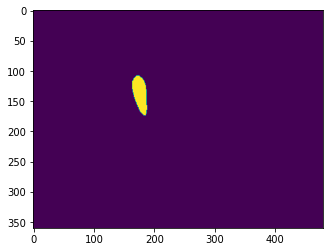

In [ ]:
masks = [mask.to(torch.device('cpu')).detach().numpy()[0] for mask in output_test[0]["masks"]]
mask = np.zeros(masks[0].shape)
for m in masks:
    mask = np.logical_or(mask, m > 0.5)
plt.imshow(mask)

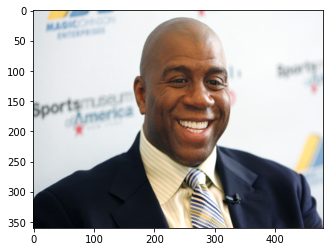

In [ ]:
img = cv2.imread(f"data/ears/train/{targets[0]['image_id'].detach().numpy()[0]+1:04d}.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

### Load trained model

In [ ]:
model = CNNEarDetector(backbone="mobile_net")
model.load(os.getcwd(), "trained_mobile")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

### Make predictions

In [ ]:
test_data = AWETestSet(os.path.join(os.getcwd(), "data/ears"), get_transform())

test_data_loader = torch.utils.data.DataLoader(
 test_data, batch_size=1, shuffle=False, num_workers=2,
 collate_fn=utils.collate_fn)

In [ ]:
model.store_predictions(test_data_loader, os.getcwd(), "predictions_mobile")

Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100
Iteration 110
Iteration 120
Iteration 130
Iteration 140
Iteration 150
Iteration 160
Iteration 170
Iteration 180
Iteration 190
Iteration 200
Iteration 210
Iteration 220
Iteration 230
Iteration 240


## Histogram equalization

### Load data

In [ ]:
train_data = AWETrainSet(os.path.join(os.getcwd(), "data/ears"), get_transform_equalization())
train_data[0]

(tensor([[[0.2784, 0.2627, 0.2510,  ..., 0.0510, 0.0000, 0.0000],
          [0.2706, 0.2510, 0.2510,  ..., 0.0510, 0.0000, 0.0000],
          [0.2471, 0.2392, 0.2510,  ..., 0.0392, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.2039, 0.1529, 0.0235],
          [0.0000, 0.0000, 0.0000,  ..., 0.1882, 0.1373, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.2078, 0.1333, 0.0078]],
 
         [[0.7294, 0.7137, 0.6980,  ..., 0.4157, 0.2157, 0.0392],
          [0.7216, 0.7020, 0.6980,  ..., 0.4157, 0.1961, 0.0353],
          [0.7020, 0.6941, 0.7098,  ..., 0.4039, 0.1961, 0.0275],
          ...,
          [0.0471, 0.0431, 0.0392,  ..., 0.6627, 0.5765, 0.4353],
          [0.0471, 0.0471, 0.0353,  ..., 0.6549, 0.5725, 0.4039],
          [0.0431, 0.0392, 0.0353,  ..., 0.6745, 0.5765, 0.4196]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.8118, 0.6471],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.8039, 0.6431],
          [1.0000, 1.0000, 1.0000,  ...,

### Train and save model

In [ ]:
model = CNNEarDetector(backbone = "mobile_net")
model.set_otpimizer(learning_rate=5e-4, weight_decay=1e-2)
model.train(train_data, num_epochs=5)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

Training model on GPUs


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [  0/375]  eta: 0:17:31  lr: 0.000002  loss: 9.8097 (9.8097)  loss_classifier: 0.6174 (0.6174)  loss_box_reg: 0.0210 (0.0210)  loss_mask: 8.4183 (8.4183)  loss_objectness: 0.7479 (0.7479)  loss_rpn_box_reg: 0.0052 (0.0052)  time: 2.8034  data: 1.5257  max mem: 3737
Epoch: [0]  [ 10/375]  eta: 0:06:36  lr: 0.000015  loss: 7.6649 (7.2987)  loss_classifier: 0.1638 (0.2577)  loss_box_reg: 0.0082 (0.0122)  loss_mask: 6.6903 (6.3465)  loss_objectness: 0.6959 (0.6763)  loss_rpn_box_reg: 0.0052 (0.0059)  time: 1.0856  data: 0.1517  max mem: 4717
Epoch: [0]  [ 20/375]  eta: 0:05:55  lr: 0.000029  loss: 4.5073 (5.3245)  loss_classifier: 0.0549 (0.1570)  loss_box_reg: 0.0041 (0.0088)  loss_mask: 3.8806 (4.6227)  loss_objectness: 0.5170 (0.5297)  loss_rpn_box_reg: 0.0055 (0.0063)  time: 0.9102  data: 0.0133  max mem: 4717
Epoch: [0]  [ 30/375]  eta: 0:05:34  lr: 0.000042  loss: 2.4770 (4.3186)  loss_classifier: 0.0444 (0.1231)  loss_box_reg: 0.0032 (0.0073)  loss_mask: 2.1466 (3.7780) 

In [ ]:
model.save(os.getcwd(), "trained_mobile_equalization")

### Quick test

In [ ]:
data_loader = torch.utils.data.DataLoader(
 train_data, batch_size=2, shuffle=True, num_workers=4,
 collate_fn=utils.collate_fn)
# For Training
images,targets = next(iter(data_loader))
images = list(image.to(torch.device('cuda')) for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
#output_train = model(images,targets)
model.set_eval()
output_test = model(images)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
output_test

[{'boxes': tensor([[129.3316, 120.1959, 165.0753, 197.0944],
          [348.4649, 149.8104, 365.9770, 194.6217],
          [123.8667, 125.5237, 188.7192, 186.8639],
          [353.8683, 151.2339, 366.8342, 173.0043]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 1, 1, 1], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
   

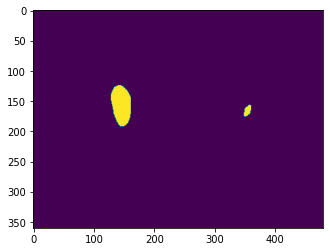

In [ ]:
masks = [mask.to(torch.device('cpu')).detach().numpy()[0] for mask in output_test[0]["masks"]]
mask = np.zeros(masks[0].shape)
for m in masks:
    mask = np.logical_or(mask, m > 0.5)
plt.imshow(mask)

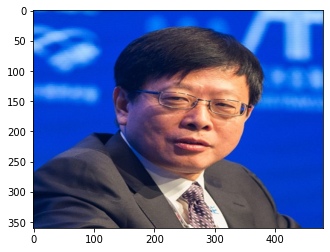

In [ ]:
img = cv2.imread(f"data/ears/train/{targets[0]['image_id'].detach().numpy()[0]+1:04d}.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

### Load trained model

In [ ]:
model = CNNEarDetector(backbone="mobile_net")
model.load(os.getcwd(), "trained_mobile_equalization")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

### Make predictions

In [ ]:
test_data = AWETestSet(os.path.join(os.getcwd(), "data/ears"), get_transform_equalization())

test_data_loader = torch.utils.data.DataLoader(
 test_data, batch_size=1, shuffle=False, num_workers=2,
 collate_fn=utils.collate_fn)

In [ ]:
model.store_predictions(test_data_loader, os.getcwd(), "predictions_mobile_equalization")

Iteration 0


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100
Iteration 110
Iteration 120
Iteration 130
Iteration 140
Iteration 150
Iteration 160
Iteration 170
Iteration 180
Iteration 190
Iteration 200
Iteration 210
Iteration 220
Iteration 230
Iteration 240


## Edge enhancement

### Load data

In [ ]:
train_data = AWETrainSet(os.path.join(os.getcwd(), "data/ears"), get_transform_edge())
train_data[0]

(tensor([[[0.1961, 0.0863, 0.0471,  ..., 0.0000, 0.0118, 0.0118],
          [0.1490, 0.0353, 0.0706,  ..., 0.0000, 0.0157, 0.0000],
          [0.1059, 0.0549, 0.1176,  ..., 0.0000, 0.0235, 0.0000],
          ...,
          [0.0235, 0.0000, 0.0000,  ..., 0.0745, 0.1412, 0.0000],
          [0.0235, 0.0000, 0.0000,  ..., 0.0118, 0.0784, 0.0000],
          [0.0627, 0.0000, 0.0000,  ..., 0.1059, 0.0588, 0.0000]],
 
         [[0.6549, 0.5059, 0.4784,  ..., 0.4706, 0.3765, 0.0000],
          [0.5843, 0.4706, 0.5176,  ..., 0.4784, 0.3451, 0.0000],
          [0.5529, 0.5020, 0.5725,  ..., 0.4588, 0.3686, 0.0000],
          ...,
          [0.2471, 0.2078, 0.1843,  ..., 0.6118, 0.5333, 0.0863],
          [0.2588, 0.2196, 0.1569,  ..., 0.6000, 0.5098, 0.0392],
          [0.2196, 0.1843, 0.1608,  ..., 0.7333, 0.5255, 0.0941]],
 
         [[1.0000, 0.9608, 0.9176,  ..., 1.0000, 0.9255, 0.3804],
          [0.9922, 0.8941, 0.9647,  ..., 1.0000, 0.9333, 0.3843],
          [0.9255, 0.8902, 1.0000,  ...,

### Train and save model

In [ ]:
model = CNNEarDetector(backbone = "mobile_net")
model.set_otpimizer(learning_rate=5e-4, weight_decay=1e-2)
model.train(train_data, num_epochs=5)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

Training model on GPUs


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [  0/375]  eta: 0:18:15  lr: 0.000002  loss: 11.9483 (11.9483)  loss_classifier: 0.7041 (0.7041)  loss_box_reg: 0.0030 (0.0030)  loss_mask: 10.5682 (10.5682)  loss_objectness: 0.6659 (0.6659)  loss_rpn_box_reg: 0.0071 (0.0071)  time: 2.9211  data: 1.5690  max mem: 3737
Epoch: [0]  [ 10/375]  eta: 0:11:13  lr: 0.000015  loss: 5.9392 (6.3577)  loss_classifier: 0.1838 (0.2931)  loss_box_reg: 0.0030 (0.0033)  loss_mask: 5.0196 (5.4467)  loss_objectness: 0.6332 (0.6086)  loss_rpn_box_reg: 0.0060 (0.0060)  time: 1.8460  data: 0.7398  max mem: 4725
Epoch: [0]  [ 20/375]  eta: 0:08:46  lr: 0.000029  loss: 4.6087 (5.2544)  loss_classifier: 0.0586 (0.1787)  loss_box_reg: 0.0007 (0.0021)  loss_mask: 4.0290 (4.5861)  loss_objectness: 0.4721 (0.4811)  loss_rpn_box_reg: 0.0053 (0.0064)  time: 1.4099  data: 0.3344  max mem: 4725
Epoch: [0]  [ 30/375]  eta: 0:07:46  lr: 0.000042  loss: 2.7744 (4.3501)  loss_classifier: 0.0507 (0.1392)  loss_box_reg: 0.0004 (0.0018)  loss_mask: 2.6237 (3.83

In [ ]:
model.save(os.getcwd(), "trained_mobile_edge")

### Quick test

In [ ]:
data_loader = torch.utils.data.DataLoader(
 train_data, batch_size=2, shuffle=True, num_workers=4,
 collate_fn=utils.collate_fn)
# For Training
images,targets = next(iter(data_loader))
images = list(image.to(torch.device('cuda')) for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
#output_train = model(images,targets)
model.set_eval()
output_test = model(images)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
output_test

[{'boxes': tensor([[307.1214,  37.6985, 341.3014, 114.9376],
          [295.5636,  35.3041, 357.7969, 129.5726],
          [306.2419,  69.0467, 335.7148, 115.0788],
          [318.9924,  41.8548, 349.1908, 113.6439]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 1, 1, 1], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
   

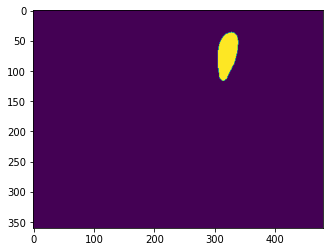

In [ ]:
masks = [mask.to(torch.device('cpu')).detach().numpy()[0] for mask in output_test[0]["masks"]]
mask = np.zeros(masks[0].shape)
for m in masks:
    mask = np.logical_or(mask, m > 0.5)
plt.imshow(mask)

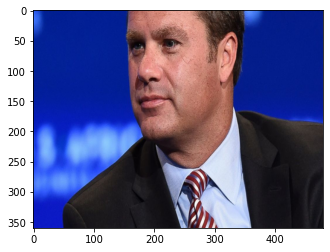

In [ ]:
img = cv2.imread(f"data/ears/train/{targets[0]['image_id'].detach().numpy()[0]+1:04d}.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

### Load trained model

In [ ]:
model = CNNEarDetector(backbone="mobile_net")
model.load(os.getcwd(), "trained_mobile_edge")

### Make predictions

In [ ]:
test_data = AWETestSet(os.path.join(os.getcwd(), "data/ears"), get_transform_edge())

test_data_loader = torch.utils.data.DataLoader(
 test_data, batch_size=1, shuffle=False, num_workers=2,
 collate_fn=utils.collate_fn)

In [ ]:
model.store_predictions(test_data_loader, os.getcwd(), "predictions_mobile_edge")

Iteration 0


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100
Iteration 110
Iteration 120
Iteration 130
Iteration 140
Iteration 150
Iteration 160
Iteration 170
Iteration 180
Iteration 190
Iteration 200
Iteration 210
Iteration 220
Iteration 230
Iteration 240


## Image sharpening

### Load data

In [ ]:
train_data = AWETrainSet(os.path.join(os.getcwd(), "data/ears"), get_transform_sharpening())
train_data[0]

(tensor([[[0.0902, 0.0706, 0.0588,  ..., 0.0039, 0.0039, 0.0039],
          [0.0784, 0.0588, 0.0588,  ..., 0.0039, 0.0039, 1.0000],
          [0.0588, 0.0510, 0.0627,  ..., 1.0000, 0.0039, 1.0000],
          ...,
          [0.0039, 0.0000, 0.0000,  ..., 0.0549, 0.0510, 0.9922],
          [0.0039, 0.0000, 0.0000,  ..., 0.0392, 0.0392, 0.9843],
          [0.0118, 0.0000, 0.0000,  ..., 0.0588, 0.0314, 0.9961]],
 
         [[0.5373, 0.5098, 0.4980,  ..., 0.3804, 0.3020, 0.1569],
          [0.5255, 0.5020, 0.5059,  ..., 0.3804, 0.2941, 0.1490],
          [0.5137, 0.5059, 0.5176,  ..., 0.3765, 0.2980, 0.1451],
          ...,
          [0.2039, 0.1922, 0.1804,  ..., 0.5176, 0.4745, 0.3804],
          [0.2039, 0.1961, 0.1725,  ..., 0.5137, 0.4667, 0.3647],
          [0.2000, 0.1882, 0.1725,  ..., 0.5373, 0.4706, 0.3765]],
 
         [[0.9608, 0.9451, 0.9333,  ..., 0.9882, 0.8941, 0.7686],
          [0.9451, 0.9294, 0.9451,  ..., 0.9882, 0.8941, 0.7686],
          [0.9255, 0.9255, 0.9529,  ...,

### Train and save model

In [ ]:
model = CNNEarDetector(backbone = "mobile_net")
model.set_otpimizer(learning_rate=5e-4, weight_decay=1e-2)
model.train(train_data, num_epochs=5)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

Training model on GPUs


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [  0/375]  eta: 0:17:27  lr: 0.000002  loss: 9.6729 (9.6729)  loss_classifier: 0.6473 (0.6473)  loss_box_reg: 0.0090 (0.0090)  loss_mask: 8.2770 (8.2770)  loss_objectness: 0.7333 (0.7333)  loss_rpn_box_reg: 0.0062 (0.0062)  time: 2.7936  data: 1.3675  max mem: 3737
Epoch: [0]  [ 10/375]  eta: 0:08:20  lr: 0.000015  loss: 7.7713 (7.6246)  loss_classifier: 0.1484 (0.2621)  loss_box_reg: 0.0032 (0.0056)  loss_mask: 6.6761 (6.6989)  loss_objectness: 0.6704 (0.6532)  loss_rpn_box_reg: 0.0052 (0.0048)  time: 1.3707  data: 0.3875  max mem: 4725
Epoch: [0]  [ 20/375]  eta: 0:06:37  lr: 0.000029  loss: 4.5599 (5.8006)  loss_classifier: 0.0557 (0.1602)  loss_box_reg: 0.0021 (0.0052)  loss_mask: 3.8278 (5.1198)  loss_objectness: 0.4980 (0.5106)  loss_rpn_box_reg: 0.0035 (0.0048)  time: 1.0360  data: 0.1512  max mem: 4725
Epoch: [0]  [ 30/375]  eta: 0:05:55  lr: 0.000042  loss: 2.9837 (4.7043)  loss_classifier: 0.0512 (0.1262)  loss_box_reg: 0.0021 (0.0049)  loss_mask: 2.6108 (4.1778) 

In [ ]:
model.save(os.getcwd(), "trained_mobile_sharpening")

### Quick test

In [ ]:
data_loader = torch.utils.data.DataLoader(
 train_data, batch_size=2, shuffle=True, num_workers=4,
 collate_fn=utils.collate_fn)
# For Training
images,targets = next(iter(data_loader))
images = list(image.to(torch.device('cuda')) for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
#output_train = model(images,targets)
model.set_eval()
output_test = model(images)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
output_test

[{'boxes': tensor([[ 47.6957,  68.3643, 116.0132, 230.1911],
          [ 67.4745, 111.0625, 112.8441, 215.8296],
          [ 50.1871,  70.9570,  88.0535, 163.9111],
          [ 53.1939,  72.3444,  72.7100, 135.6014],
          [ 56.1851, 141.2767, 126.8566, 217.9094],
          [ 43.9236,  70.3488,  85.2928, 125.0049],
          [ 83.6796, 145.7639, 109.8198, 215.3972]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0

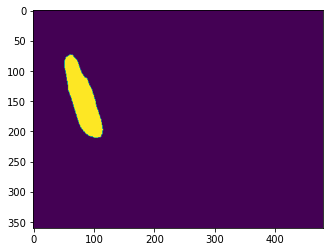

In [ ]:
masks = [mask.to(torch.device('cpu')).detach().numpy()[0] for mask in output_test[0]["masks"]]
mask = np.zeros(masks[0].shape)
for m in masks:
    mask = np.logical_or(mask, m > 0.5)
plt.imshow(mask)

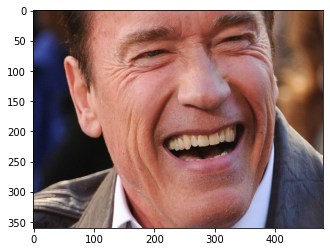

In [ ]:
img = cv2.imread(f"data/ears/train/{targets[0]['image_id'].detach().numpy()[0]+1:04d}.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

### Load trained model

In [ ]:
model = CNNEarDetector(backbone="mobile_net")
model.load(os.getcwd(), "trained_mobile_sharpening")

### Make predictions

In [ ]:
test_data = AWETestSet(os.path.join(os.getcwd(), "data/ears"), get_transform_sharpening())

test_data_loader = torch.utils.data.DataLoader(
 test_data, batch_size=1, shuffle=False, num_workers=2,
 collate_fn=utils.collate_fn)

In [ ]:
model.store_predictions(test_data_loader, os.getcwd(), "predictions_mobile_sharpening")

Iteration 0


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100
Iteration 110
Iteration 120
Iteration 130
Iteration 140
Iteration 150
Iteration 160
Iteration 170
Iteration 180
Iteration 190
Iteration 200
Iteration 210
Iteration 220
Iteration 230
Iteration 240


## Histogram equalization and image sharpening

### Load data

In [6]:
train_data = AWETrainSet(os.path.join(os.getcwd(), "data/ears"), get_transform_combined())
train_data[0]

(tensor([[[0.2078, 0.1882, 0.1686,  ..., 0.0314, 0.0000, 0.0000],
          [0.1961, 0.1686, 0.1725,  ..., 0.0314, 0.0000, 1.0000],
          [0.1725, 0.1647, 0.1804,  ..., 1.0000, 0.0000, 1.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.1529, 0.1176, 1.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.1333, 0.1020, 1.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.1686, 0.0902, 1.0000]],
 
         [[0.6588, 0.6275, 0.6078,  ..., 0.4118, 0.1882, 0.0000],
          [0.6471, 0.6196, 0.6196,  ..., 0.4118, 0.1765, 0.2745],
          [0.6235, 0.6235, 0.6353,  ..., 0.5686, 0.1882, 0.2706],
          ...,
          [0.0510, 0.0431, 0.0392,  ..., 0.6196, 0.5412, 0.5451],
          [0.0510, 0.0431, 0.0314,  ..., 0.6118, 0.5255, 0.5216],
          [0.0392, 0.0392, 0.0275,  ..., 0.6431, 0.5333, 0.5412]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.7882, 0.6078],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.7804, 0.8902],
          [1.0000, 1.0000, 1.0000,  ...,

### Train and save model

In [7]:
model = CNNEarDetector(backbone = "mobile_net")
model.set_otpimizer(learning_rate=5e-4, weight_decay=1e-2)
model.train(train_data, num_epochs=5)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

Training model on GPUs


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [  0/375]  eta: 0:20:39  lr: 0.000002  loss: 6.2404 (6.2404)  loss_classifier: 0.7113 (0.7113)  loss_box_reg: 0.0165 (0.0165)  loss_mask: 4.7876 (4.7876)  loss_objectness: 0.7224 (0.7224)  loss_rpn_box_reg: 0.0026 (0.0026)  time: 3.3044  data: 1.9251  max mem: 3737
Epoch: [0]  [ 10/375]  eta: 0:11:10  lr: 0.000015  loss: 5.8484 (5.5764)  loss_classifier: 0.1884 (0.2997)  loss_box_reg: 0.0056 (0.0081)  loss_mask: 4.5395 (4.6022)  loss_objectness: 0.6698 (0.6580)  loss_rpn_box_reg: 0.0086 (0.0084)  time: 1.8376  data: 0.7294  max mem: 4717
Epoch: [0]  [ 20/375]  eta: 0:08:44  lr: 0.000029  loss: 4.3176 (4.5732)  loss_classifier: 0.0568 (0.1775)  loss_box_reg: 0.0025 (0.0054)  loss_mask: 3.8658 (3.8635)  loss_objectness: 0.5033 (0.5186)  loss_rpn_box_reg: 0.0078 (0.0082)  time: 1.3860  data: 0.3113  max mem: 4717
Epoch: [0]  [ 30/375]  eta: 0:07:45  lr: 0.000042  loss: 2.6321 (3.9166)  loss_classifier: 0.0447 (0.1376)  loss_box_reg: 0.0019 (0.0046)  loss_mask: 2.4278 (3.3662) 

In [9]:
model.save(os.getcwd(), "trained_mobile_combined")

### Quick test

In [8]:
data_loader = torch.utils.data.DataLoader(
 train_data, batch_size=2, shuffle=True, num_workers=4,
 collate_fn=utils.collate_fn)
# For Training
images,targets = next(iter(data_loader))
images = list(image.to(torch.device('cuda')) for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
#output_train = model(images,targets)
model.set_eval()
output_test = model(images)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [10]:
output_test

[{'boxes': tensor([[360.4117, 134.6071, 377.6415, 182.7668],
          [349.6001, 126.4617, 377.3658, 190.5453],
          [352.8680, 135.4721, 370.5350, 182.6571],
          [355.5945, 163.3672, 369.8745, 183.6825],
          [355.3445, 149.6150, 369.5776, 171.5788],
          [366.2923, 145.2091, 376.9023, 170.4939],
          [355.5503, 154.8463, 380.3149, 184.1203],
          [366.0058, 158.5716, 377.0088, 182.8501],
          [355.4628, 142.2829, 380.3538, 172.0488],
          [267.3694, 240.8330, 285.4819, 296.6427],
          [353.0345, 158.4786, 364.8336, 183.3730],
          [264.2644, 229.5203, 295.0974, 312.2405],
          [351.7484, 166.1732, 371.0169, 177.8986],
          [353.1273, 145.3297, 364.4915, 171.6338]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 

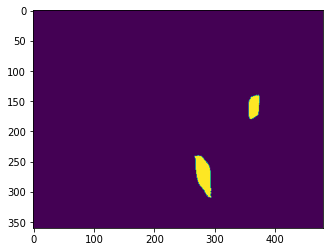

In [11]:
masks = [mask.to(torch.device('cpu')).detach().numpy()[0] for mask in output_test[0]["masks"]]
mask = np.zeros(masks[0].shape)
for m in masks:
    mask = np.logical_or(mask, m > 0.5)
plt.imshow(mask)

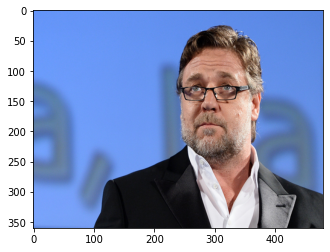

In [12]:
img = cv2.imread(f"data/ears/train/{targets[0]['image_id'].detach().numpy()[0]+1:04d}.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

### Load trained model

In [13]:
model = CNNEarDetector(backbone="mobile_net")
model.load(os.getcwd(), "trained_mobile_combined")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

### Make predictions

In [14]:
test_data = AWETestSet(os.path.join(os.getcwd(), "data/ears"), get_transform_combined())

test_data_loader = torch.utils.data.DataLoader(
 test_data, batch_size=1, shuffle=False, num_workers=2,
 collate_fn=utils.collate_fn)

In [15]:
model.store_predictions(test_data_loader, os.getcwd(), "predictions_mobile_combined")

Iteration 0


AttributeError: ignored

## Train the best model on more epochs

In [5]:
train_data = AWETrainSet(os.path.join(os.getcwd(), "data/ears"), get_transform_equalization())
train_data[0]

(tensor([[[0.2784, 0.2627, 0.2510,  ..., 0.0510, 0.0000, 0.0000],
          [0.2706, 0.2510, 0.2510,  ..., 0.0510, 0.0000, 0.0000],
          [0.2471, 0.2392, 0.2510,  ..., 0.0392, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.2039, 0.1529, 0.0235],
          [0.0000, 0.0000, 0.0000,  ..., 0.1882, 0.1373, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.2078, 0.1333, 0.0078]],
 
         [[0.7294, 0.7137, 0.6980,  ..., 0.4157, 0.2157, 0.0392],
          [0.7216, 0.7020, 0.6980,  ..., 0.4157, 0.1961, 0.0353],
          [0.7020, 0.6941, 0.7098,  ..., 0.4039, 0.1961, 0.0275],
          ...,
          [0.0471, 0.0431, 0.0392,  ..., 0.6627, 0.5765, 0.4353],
          [0.0471, 0.0471, 0.0353,  ..., 0.6549, 0.5725, 0.4039],
          [0.0431, 0.0392, 0.0353,  ..., 0.6745, 0.5765, 0.4196]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.8118, 0.6471],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.8039, 0.6431],
          [1.0000, 1.0000, 1.0000,  ...,

In [17]:
model = CNNEarDetector(backbone = "mobile_net")
model.set_otpimizer(learning_rate=5e-4, weight_decay=1e-2)
model.train(train_data, num_epochs=20)

Training model on GPUs
Epoch: [0]  [  0/375]  eta: 0:07:58  lr: 0.000002  loss: 8.6207 (8.6207)  loss_classifier: 0.6158 (0.6158)  loss_box_reg: 0.0007 (0.0007)  loss_mask: 7.2738 (7.2738)  loss_objectness: 0.7200 (0.7200)  loss_rpn_box_reg: 0.0104 (0.0104)  time: 1.2757  data: 0.1768  max mem: 7340
Epoch: [0]  [ 10/375]  eta: 0:06:43  lr: 0.000015  loss: 5.3833 (5.6967)  loss_classifier: 0.1556 (0.2527)  loss_box_reg: 0.0020 (0.0041)  loss_mask: 4.5470 (4.7823)  loss_objectness: 0.6692 (0.6511)  loss_rpn_box_reg: 0.0055 (0.0065)  time: 1.1044  data: 0.0275  max mem: 8317
Epoch: [0]  [ 20/375]  eta: 0:06:28  lr: 0.000029  loss: 3.8893 (4.5753)  loss_classifier: 0.0492 (0.1528)  loss_box_reg: 0.0016 (0.0032)  loss_mask: 3.3470 (3.9021)  loss_objectness: 0.5049 (0.5112)  loss_rpn_box_reg: 0.0054 (0.0060)  time: 1.0863  data: 0.0122  max mem: 8317
Epoch: [0]  [ 30/375]  eta: 0:06:16  lr: 0.000042  loss: 2.6177 (3.8275)  loss_classifier: 0.0515 (0.1217)  loss_box_reg: 0.0013 (0.0036)  loss

SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [18]:
model.save(os.getcwd(), "trained_mobile_best")

### Quick test

In [7]:
data_loader = torch.utils.data.DataLoader(
 train_data, batch_size=2, shuffle=True, num_workers=4,
 collate_fn=utils.collate_fn)
# For Training
images,targets = next(iter(data_loader))
#images = list(image.to(torch.device('cuda')) for image in images)
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
#output_train = model(images,targets)
model.set_eval()
output_test = model(images)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
output_test

[{'boxes': tensor([[423.1916, 101.9501, 462.1685, 147.2601],
          [104.0736, 232.3912, 120.8592, 287.7504],
          [231.2999,  88.0078, 270.9255, 133.7908],
          [106.8784, 233.1859, 118.4172, 259.4757],
          [107.1809, 244.1361, 118.6434, 272.8625],
          [443.2483, 102.1223, 465.6019, 141.8883],
          [100.6283, 226.4091, 121.8686, 321.3524],
          [ 99.1846, 242.2769, 125.0397, 273.2259],
          [ 32.3386,  31.9408,  49.1007,  82.8087]], grad_fn=<StackBackward0>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1]),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,

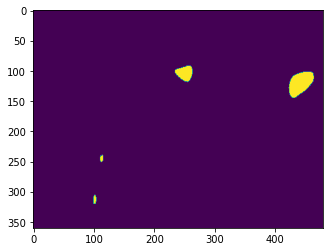

In [9]:
masks = [mask.to(torch.device('cpu')).detach().numpy()[0] for mask in output_test[0]["masks"]]
mask = np.zeros(masks[0].shape)
for m in masks:
    mask = np.logical_or(mask, m > 0.5)
plt.imshow(mask)

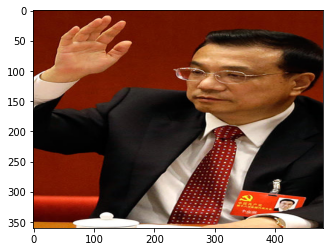

In [10]:
img = cv2.imread(f"data/ears/train/{targets[0]['image_id'].detach().numpy()[0]+1:04d}.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

### Load trained model

In [6]:
model = CNNEarDetector(backbone="mobile_net")
model.load(os.getcwd(), "trained_mobile_best")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

### Make predictions

In [11]:
test_data = AWETestSet(os.path.join(os.getcwd(), "data/ears"), get_transform_equalization())

test_data_loader = torch.utils.data.DataLoader(
 test_data, batch_size=1, shuffle=False, num_workers=2,
 collate_fn=utils.collate_fn)

In [12]:
model.store_predictions(test_data_loader, os.getcwd(), "predictions_mobile_best")

Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100
Iteration 110
Iteration 120
Iteration 130
Iteration 140
Iteration 150
Iteration 160
Iteration 170
Iteration 180
Iteration 190


IndexError: ignored